<a href="https://colab.research.google.com/github/genaiconference/Agentic_KAG/blob/main/05_agentic_kag_inference_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agentic KAG


This notebook demonstrates the capabilities of Agentic KAG, a framework for building intelligent agents that can perform complex tasks and generate answers from Knoweldge Graphs.

In [ ]:
!git clone https://github.com/genaiconference/Agentic_KAG.git

Cloning into 'Agentic_KAG'...
remote: Enumerating objects: 366, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 366 (delta 66), reused 30 (delta 30), pack-reused 268 (from 2)
Receiving objects: 100% (366/366), 7.27 MiB | 16.58 MiB/s, done.
Resolving deltas: 100% (189/189), done.


## Install Required Packages

In [ ]:
!pip install -r /content/Agentic_KAG/requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.5 MB/s 

## Load credentials from .env

In [ ]:
import os
os.chdir('/content/Agentic_KAG/')

from dotenv import load_dotenv

load_dotenv()  # This loads .env at project root

NEO4J_URI = os.getenv('AV_NEO4J_URL')
NEO4J_USERNAME = os.getenv('AV_NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('AV_NEO4J_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

# Set OPENAI_API_KEY as env variable for openai/neo4j-graphrag compatibility
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

## Initialize the Neo4j Driver
The Neo4j driver allows you to connect and perform read and write transactions with the database.

In [ ]:
from neo4j import GraphDatabase

driver = GraphDatabase.driver(
    NEO4J_URI,
    auth=(NEO4J_USERNAME, NEO4J_PASSWORD)
)

# (Optional) Test the connection
driver.verify_connectivity()

## Initialize OpenAI LLM and Embeddings via neo4j-graphrag
We will use OpenAI **GPT-4.1**. The GraphRAG Python package supports any LLM model, including models from OpenAI, Google VertexAI, Anthropic, Cohere, Azure OpenAI, local Ollama models, and any chat model that works with LangChain. You can also implement a custom interface for any other LLM.

Likewise, we will use OpenAI’s **text-embedding-3-small** for the embedding model, but you can use other embedders from different providers.

In [ ]:
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.embeddings import OpenAIEmbeddings

llm = OpenAILLM(
    model_name="gpt-4.1",
    model_params={"temperature": 0}
)

embedder = OpenAIEmbeddings(
    model="text-embedding-3-small"
)

We will also initialize langchain llm to use for community detection & Summarization

In [ ]:
from langchain_openai import ChatOpenAI

# Initialize OpenAI LLM using LangChain
lang_llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model_name="gpt-4.1", temperature=0)

Initialize OpenAI client

In [ ]:
from openai import OpenAI

open_ai_client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

## Initialize Langfuse Handler for Tracing

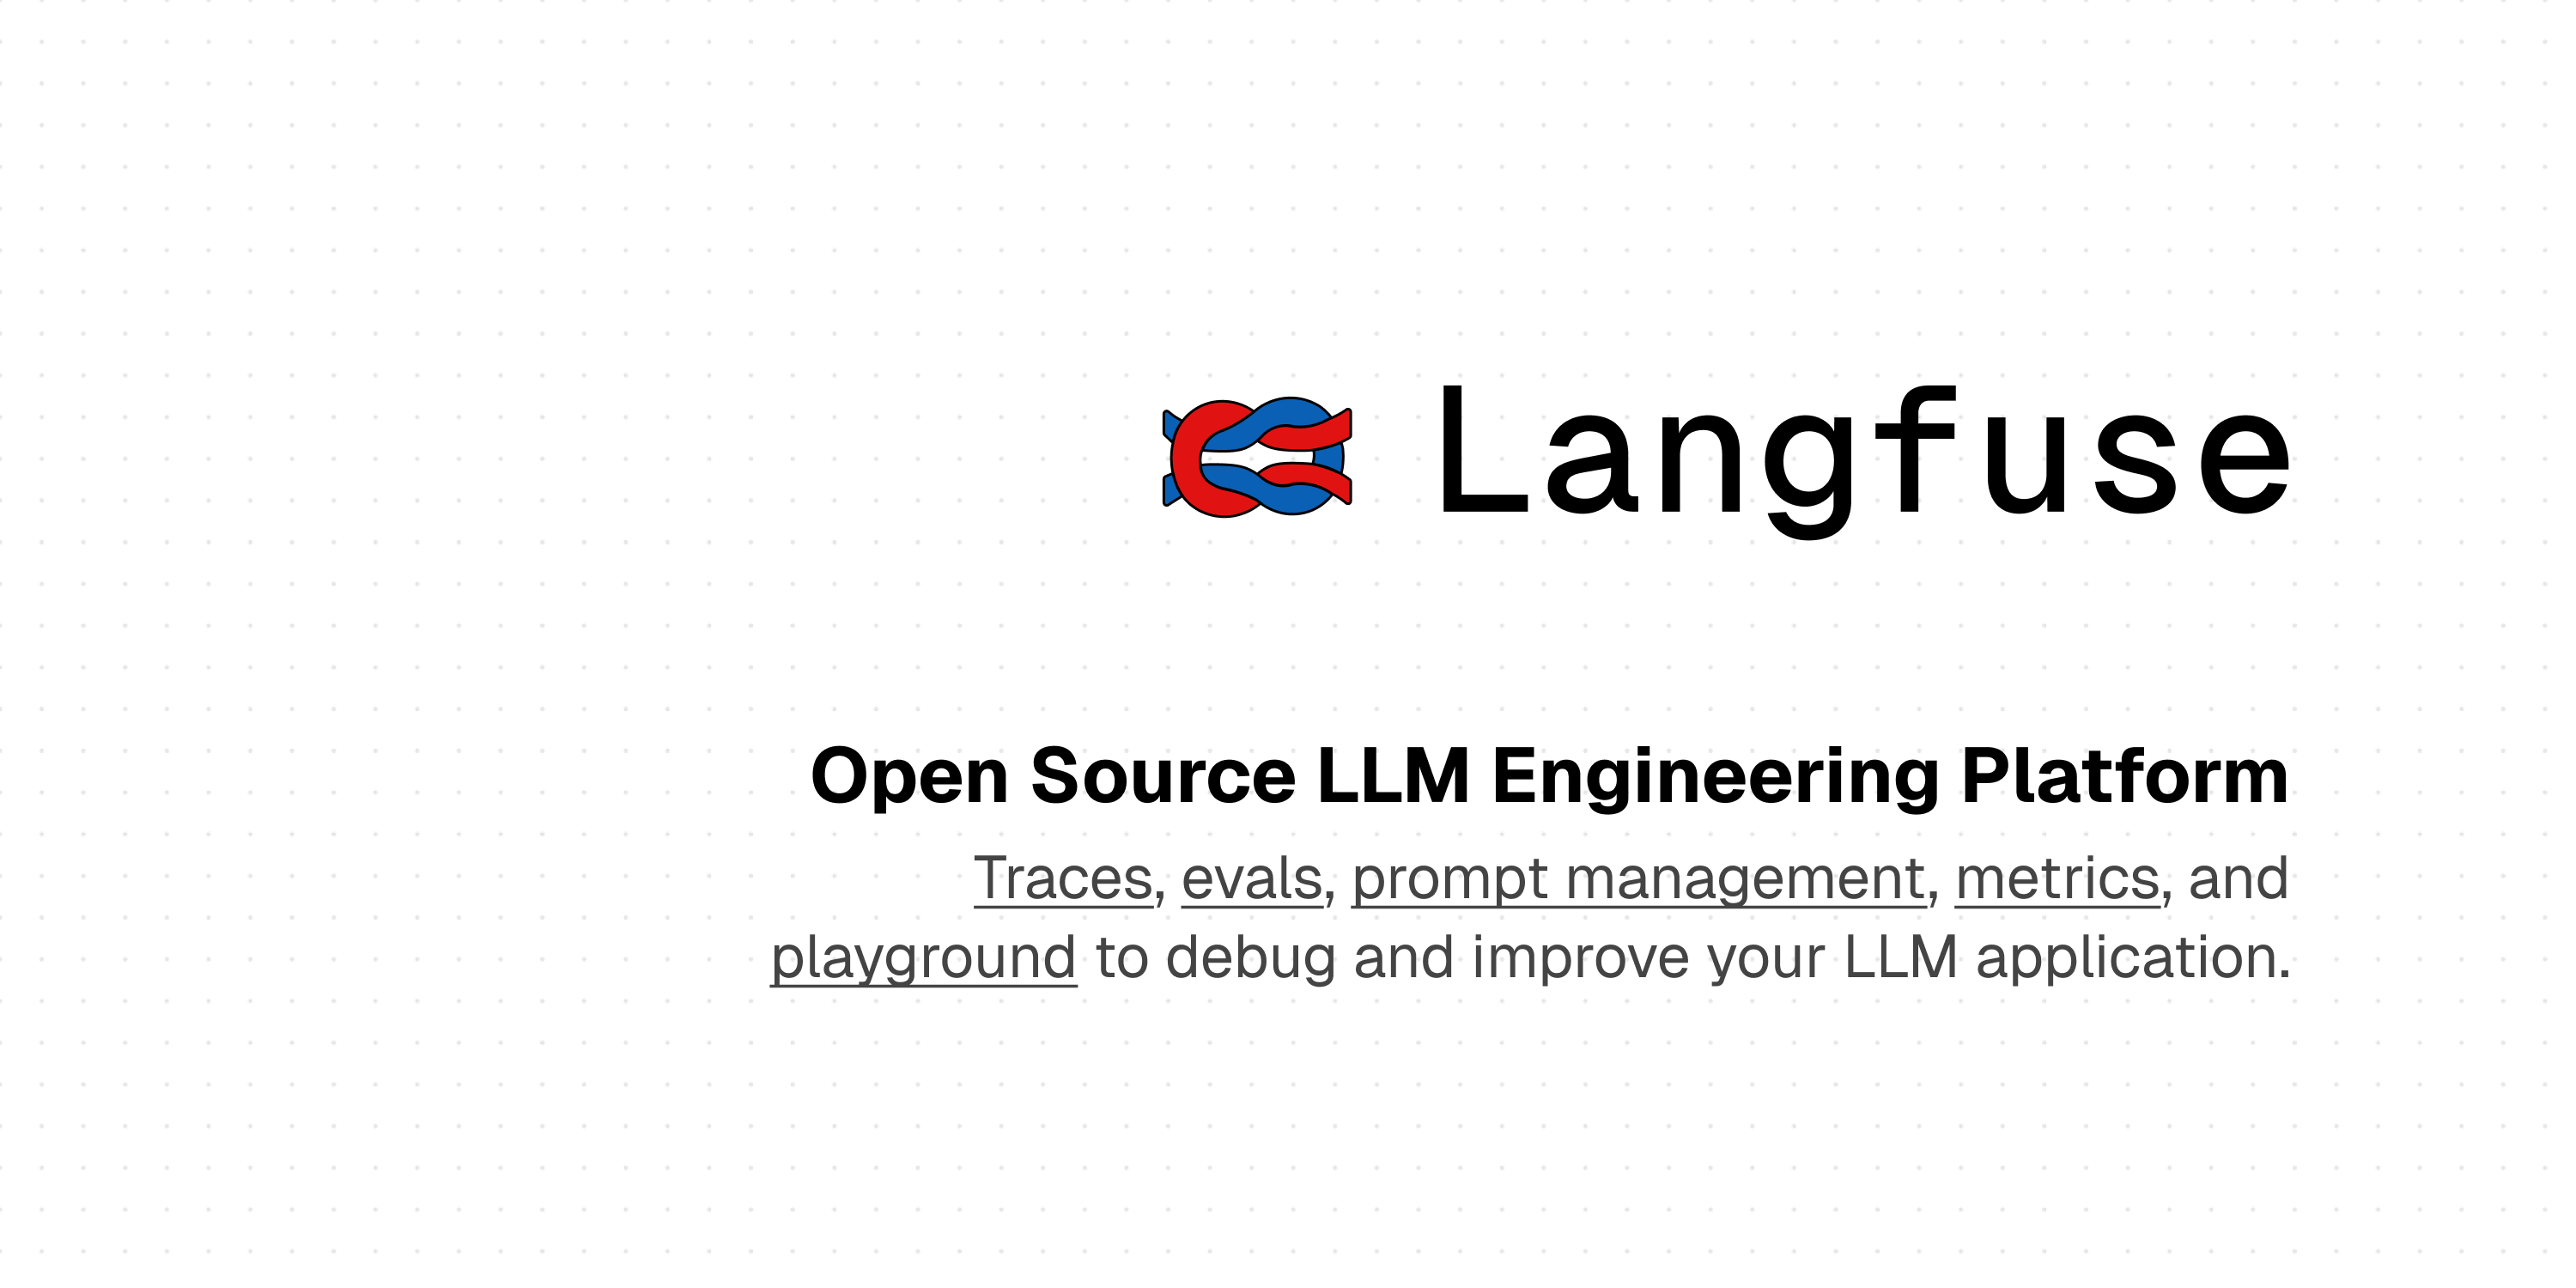

In [ ]:
from langfuse.langchain import CallbackHandler
from langfuse import get_client

os.environ["LANGFUSE_PUBLIC_KEY"] = os.getenv("LANGFUSE_PUBLIC_KEY")
os.environ["LANGFUSE_SECRET_KEY"] = os.getenv("LANGFUSE_SECRET_KEY")
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com"

langfuse = get_client()

# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

langfuse_handler = CallbackHandler()

Langfuse client is authenticated and ready!


## Define ReACT Agent

In [ ]:
from langchain.agents import AgentExecutor, create_react_agent
from langchain.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    HumanMessagePromptTemplate,
    AIMessagePromptTemplate,
    PromptTemplate,
)
import re
import asyncio
from typing import List, Union
from langchain.agents import AgentOutputParser, AgentExecutor, create_react_agent
from langchain.schema import AgentAction, AgentFinish



# 1️⃣  ───── Robust multi-action parser ────────────────────────────
class MultiActionOutputParser(AgentOutputParser):
    """
    Extract *all* Action / Action Input pairs, even when inputs are
    multi-line or there is text between blocks.
    """
    _ACTION_RE = re.compile(
        r"""Action\s*\d*:\s*(.*?)\s*\n        # tool name
            Action\ Input\s*\d*:\s*([\s\S]*?) # tool input (non-greedy)
            (?=\nAction|\nObservation|\nFinal|\Z)  # stop at next block
        """,
        flags=re.IGNORECASE | re.VERBOSE,
    )

    def parse(self, text: str) -> Union[List[AgentAction], AgentFinish]:
        # ---------- collect all tool calls ----------
        matches = self._ACTION_RE.findall(text)
        if matches:
            return [
                AgentAction(
                    tool=tool.strip(),
                    tool_input=tool_input.strip().strip('"'),
                    log=text,
                )
                for tool, tool_input in matches
            ]

        # ---------- or a final answer ----------
        # final = re.search(r"(?:Final Answer|Final Thought):\s*(.*)", text, flags=re.IGNORECASE | re.DOTALL)
        final = re.search(r"(?:Final Answer):\s*(.*)", text, flags=re.IGNORECASE | re.DOTALL)

        # final = re.search(r"(?i)Final Answer:\s*(?:\*{2})?\s*\n+(.*)", text, flags=re.IGNORECASE | re.DOTALL)   ###PushToQA 04-07-2025 fixed ** issue

        if final:
            return AgentFinish(
                return_values={"output": final.group(1).strip()}, log=text
            )

        # ---------- fallback if no Action or Final Answer but appears like final output ----------
        if text.strip():  # fallback: any non-empty text is assumed to be the final answer
            return AgentFinish(
                return_values={"output": text.strip()}, log=text
            )

        raise ValueError(f"Could not parse agent output: {text!r}")


# 2️⃣  ───── Executor that really runs in parallel ────────────────
class ParallelAgentExecutor(AgentExecutor):
    async def _aiter_next_step(self, name_to_tool_map, inputs):
        llm_output = await self.agent.aplan(
            intermediate_steps=self.intermediate_steps, **inputs
        )
        parsed = self.output_parser.parse(llm_output)

        # ----- run *all* Actions concurrently -----
        if isinstance(parsed, list):
            coros = [self._aperform_agent_action(name_to_tool_map, a) for a in parsed]
            results = await asyncio.gather(*coros)

            for a, r in zip(parsed, results):
                self.intermediate_steps.append((a, r))
                yield f"Observation: {r}\n"

        elif isinstance(parsed, AgentFinish):
            self.intermediate_steps.append(
                (parsed, parsed.return_values["output"])
            )
            yield f"Final Answer: {parsed.return_values['output']}\n"


# 3️⃣  ───── Helper to build the agent + prompt ───────────────────
def get_react_agent(llm, tools, system_prompt, verbose=False):
    """Helper function for creating agent executor"""
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="conversation_history", optional=True),
        HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}')),
        AIMessagePromptTemplate(
            prompt=PromptTemplate(input_variables=['agent_scratchpad'], template='{agent_scratchpad}')),
    ])
    agent = create_react_agent(llm, tools, prompt, output_parser=MultiActionOutputParser())

    executor = ParallelAgentExecutor(agent=agent,
                                     tools=tools,
                                     verbose=verbose,
                                     stream_runnable=True,
                                     handle_parsing_errors=True,
                                     max_iterations=20,
                                     return_intermediate_steps=True,
                                     )
    return executor

In [ ]:
# from neo4j_graphrag.schema import get_schema
# get_schema(driver)

## Define Tools

Defining 4 tools used by the ReACT agent:

- **Hybrid Retrieval tool**
- **Hybrid Cypher Retrieval tool**
- **Global Search tool**
- **Local search tool**

In [ ]:
from tools import av_hybrid_tool, av_hybrid_cypher_tool, global_retriever_tool, local_retriever_tool

Got 26 community summaries


## Agentic KAG Pipeline

In [ ]:
from IPython.display import Markdown
import json
import prompts


def run_agentic_kag(query):
    """
    Runs the answer using react agent and provided tools.
    """
    # Run Hybrid Retrieval using all the available tools
    hybrid_agent = get_react_agent(
        lang_llm,
        [av_hybrid_tool, av_hybrid_cypher_tool, global_retriever_tool, local_retriever_tool],
        prompts.REACT_PROMPT,
        verbose=True
    )
    hybrid_input = json.dumps({
        "query": query,
    })
    answer = hybrid_agent.invoke({"input": hybrid_input,
                                  "SYSTEM_PROMPT" : prompts.AV_SYSTEM_PROMPT,
                                  }, config={"callbacks": [langfuse_handler]})
    final_answer = answer['output']
    return final_answer

In [ ]:
from datetime import datetime
import pytz

def get_ist_datetime():
    """Return current IST date and time as separate strings."""
    ist = pytz.timezone("Asia/Kolkata")
    now_ist = datetime.now(ist)

    current_date = now_ist.strftime("%Y-%m-%d")
    current_time = now_ist.strftime("%H:%M")

    return current_date, current_time

def expand_question(question):
    """
    expand the originla quesiton with current date and time info
    """
    date_str, time_str = get_ist_datetime()
    question = f"{question} Current Date: {date_str} Current Time: {time_str}"
    return question

## Let's test some questions

In [ ]:
query = "which are the top themes covered in the conference"
answer = run_agentic_kag(query)
display(Markdown(answer))



> Entering new ParallelAgentExecutor chain...
Question: {"query": "which are the top themes covered in the conference"}

Thought: To answer this, I need to retrieve the main or most prominent themes/topics featured at DHS 2025. This is a broad, open-ended query about the overall content of the conference.
Action: GlobalRetrieval
Action Input: top themes covered in DHS 2025

Processing communities in parallel: 100%|██████████| 26/26 [00:26<00:00,  1.04s/it]


# Top Themes Covered in DHS 2025

DHS 2025 (DataHack Summit 2025) is characterized by a comprehensive focus on the latest advancements and practical applications in AI, with a strong emphasis on agentic systems, large language models, responsible AI, and production-grade deployment. The following sections synthesize the key themes and their implications, as supported by the dataset.

---

## 1. Agentic AI and Multi-Agent Systems

Agentic AI is a central theme, with extensive coverage of agent architectures, multi-agent patterns, and real-world deployment. Workshops and sessions explore the design, integration, and scaling of agentic systems, including memory management, retrieval, and reinforcement learning (RL) algorithms. Multi-agent systems are highlighted through hands-on workshops, practical design choices, and comparative analyses of frameworks such as AutoGen, CrewAI, and LangGraph [Data: Reports (1, Bhaskarjit Sarmah workshop, Krishnakumar Menon session, LangMem, FastMCP, NVIDI

Final Thought: The main themes of DHS 2025 are well-documented in the retrieved data, covering agentic AI, LLMs, responsible AI, productionization, evaluation, applied business impact, interoperability, and community collaboration.
Final Answer: 

**Top Themes Covered in DHS 2025**

- **Agentic AI and Multi-Agent Systems**
  - Architectures, design, scaling, and real-world deployment of agentic and multi-agent systems.
  - Frameworks like AutoGen, CrewAI, LangGraph, and hands-on workshops.

- **Large Language Models (LLMs) and LLMOps**
  - Core mechanisms, deployment, monitoring, and management of LLMs.
  - Focus on RAG, SageMaker, CI/CD, hallucination detection, and memory systems.

- **Reliability, Safety, and Responsible AI**
  - Confidence quantification, uncertainty estimation, hallucination mitigation.
  - Governance, fairness, explainability, and operationalizing responsible AI in critical domains.

- **Productionizing GenAI and Agentic Systems**
  - Scalable deployment, optimiz

**Top Themes Covered in DHS 2025**

- **Agentic AI and Multi-Agent Systems**
  - Architectures, design, scaling, and real-world deployment of agentic and multi-agent systems.
  - Frameworks like AutoGen, CrewAI, LangGraph, and hands-on workshops.

- **Large Language Models (LLMs) and LLMOps**
  - Core mechanisms, deployment, monitoring, and management of LLMs.
  - Focus on RAG, SageMaker, CI/CD, hallucination detection, and memory systems.

- **Reliability, Safety, and Responsible AI**
  - Confidence quantification, uncertainty estimation, hallucination mitigation.
  - Governance, fairness, explainability, and operationalizing responsible AI in critical domains.

- **Productionizing GenAI and Agentic Systems**
  - Scalable deployment, optimization, serverless workflows, and real-time integration.
  - Emphasis on robust, secure, and maintainable AI systems.

- **Evaluation, Observability, and Security**
  - Lifecycle design, programmatic evaluation, observability, and telemetry.
  - Security, adversarial simulation, and compliance with global frameworks.

- **Applied AI Domains and Business Impact**
  - Use cases in CX, healthcare, energy, marketing, and automotive.
  - Demonstrating business value through real-world applications.

- **Interoperability, No-Code AI, and Tooling**
  - Protocols for agent interoperability, no-code automation, and workflow building.
  - Vendor-led sessions on practical tools and best practices.

- **Community, Collaboration, and Research Excellence**
  - Cross-industry collaboration, recognition of contributors, and research-industry partnerships.

---

DHS 2025 is a comprehensive event bridging foundational research and practical deployment, with a strong focus on responsible, scalable, and collaborative AI innovation across industries.

---

If you found this helpful, do spread the word and recommend this app to your fellow attendees: [http://agentickag.dhs25.analyticsvidhya.com/](http://agentickag.dhs25.analyticsvidhya.com/)

In [ ]:
query = "List down all the sessions or workshops which uses Neo4j?"
answer = run_agentic_kag(query)
display(Markdown(answer))



> Entering new ParallelAgentExecutor chain...
Question: {"query": "List down all the sessions or workshops which uses Neo4j?"}

Thought: I need to identify all sessions or workshops that mention or utilize Neo4j. This requires searching for both direct mentions and related topics within the session and workshop data.
Action: AVHybridCypher
Action Input: "sessions or workshops that use or mention Neo4j"MATCH (s:Session)
WHERE ANY(tool IN s.tools_discussed WHERE toLower(tool) CONTAINS toLower('neo4j')) OR toLower(s.description) CONTAINS toLower('neo4j') OR toLower(s.title) CONTAINS toLower('neo4j')
RETURN s.title AS name, s.description AS description, s.instructor AS instructor, s.session_type AS type, s.theme AS theme, s.tools_discussed AS tools, s.level AS level, s.start_time AS start_time, s.end_time AS end_time, s.day AS day, s.date AS date
UNION
MATCH (w:Workshop)
WHERE ANY(tool IN w.tools_used WHERE toLower(tool) CONTAINS toLower('neo4j')) OR toLower(w.description) CONTAINS toLow

Final Thought: I have identified all sessions and workshops at DHS 2025 that use or mention Neo4j, including both a hack session and a workshop with explicit references to the Neo4j graph database.

Final Answer: 

**Sessions and Workshops at DHS 2025 that use Neo4j:**

- **Agentic Knowledge Augmented Generation: The Next Leap After RAG**
  - Type: Hack Session
  - Mentions and uses: **Neo4j Graph Database**

- **Agentic RAG Workshop: From Fundamentals to Real-World Implementations**
  - Type: Workshop
  - Includes a bonus on: **Graph RAG using Neo4j**
  - Listed tool: **Neo4j**

If you found this helpful, do spread the word and recommend this app to your fellow attendees! You can access it at [http://agentickag.dhs25.analyticsvidhya.com/](http://agentickag.dhs25.analyticsvidhya.com/) 🚀

> Finished chain.


**Sessions and Workshops at DHS 2025 that use Neo4j:**

- **Agentic Knowledge Augmented Generation: The Next Leap After RAG**
  - Type: Hack Session
  - Mentions and uses: **Neo4j Graph Database**

- **Agentic RAG Workshop: From Fundamentals to Real-World Implementations**
  - Type: Workshop
  - Includes a bonus on: **Graph RAG using Neo4j**
  - Listed tool: **Neo4j**

If you found this helpful, do spread the word and recommend this app to your fellow attendees! You can access it at [http://agentickag.dhs25.analyticsvidhya.com/](http://agentickag.dhs25.analyticsvidhya.com/) 🚀

In [ ]:
query = "Who is covering autogen? do we have any workshops "
answer = run_agentic_kag(query)
display(Markdown(answer))



> Entering new ParallelAgentExecutor chain...
Question: {"query": "Who is covering autogen? do we have any workshops "}

Thought: I need to identify sessions or workshops related to "autogen" and find out who is presenting or leading them.
Action: GlobalRetrieval
Action Input: "autogen sessions and workshops"

Processing communities in parallel: 100%|██████████| 26/26 [00:15<00:00,  1.64it/s]


# Overview of Autogen Sessions and Workshops

The dataset reveals a rich landscape of sessions and workshops focused on autogen (autonomous agent generation), agentic AI, and related multi-agent systems. These events span hands-on technical workshops, hack sessions, and panel discussions, often led by industry and academic experts. Below is a synthesis of the key sessions, their content, and implications.

---

## Core Workshops and Sessions

### 1. Mastering Real-World Agentic AI Applications with AG2 (AutoGen)
- **Description:** A hands-on technical workshop dedicated to production-grade agent design, integration, and deployment using AG2 (AutoGen) and related tools.
- **Leaders:** Hrushikesh Dokala (Atlan; fAIght Club), Dr. Qingyun Wu (AG2; Penn State), Chi Wang (AG2; FLAML), with speakers from Google/DeepMind and Serrano Academy.
- **Curriculum:** Covers fundamentals to deployment (including FastAgency and MCPs), and application domains such as customer support, marketing, content,

Final Thought: I have gathered comprehensive information on who is covering autogen at DHS 2025 and the workshops available, including key leaders, session themes, and practical details.
Final Answer: 

**Autogen Coverage at DHS 2025: Sessions & Workshops**

---

**Key Workshops & Who’s Leading Them:**

- **Mastering Real-World Agentic AI Applications with AG2 (AutoGen)**
  - **Leaders:** Hrushikesh Dokala (Atlan; fAIght Club), Dr. Qingyun Wu (AG2; Penn State), Chi Wang (AG2; FLAML), plus speakers from Google/DeepMind and Serrano Academy.
  - **Focus:** Production-grade agent design, integration, deployment, reliability, and security.

- **MassGen and Guardrails Workshop**
  - **Leaders:** Multiple, including contributors to AG2/AutoGen.
  - **Focus:** Multi-agent collaboration, alignment, bias/toxicity controls, and output governance.

- **Agentic AI and Multi-Agent Systems Workshops**
  - **Leaders:** Alessandro Romano and others.
  - **Focus:** Hands-on agentic AI, multi-agent syste

**Autogen Coverage at DHS 2025: Sessions & Workshops**

---

**Key Workshops & Who’s Leading Them:**

- **Mastering Real-World Agentic AI Applications with AG2 (AutoGen)**
  - **Leaders:** Hrushikesh Dokala (Atlan; fAIght Club), Dr. Qingyun Wu (AG2; Penn State), Chi Wang (AG2; FLAML), plus speakers from Google/DeepMind and Serrano Academy.
  - **Focus:** Production-grade agent design, integration, deployment, reliability, and security.

- **MassGen and Guardrails Workshop**
  - **Leaders:** Multiple, including contributors to AG2/AutoGen.
  - **Focus:** Multi-agent collaboration, alignment, bias/toxicity controls, and output governance.

- **Agentic AI and Multi-Agent Systems Workshops**
  - **Leaders:** Alessandro Romano and others.
  - **Focus:** Hands-on agentic AI, multi-agent systems, and no-code orchestration.

- **End-to-End LLM and Agentic AI Workshops**
  - **Leaders:** Raghav Bali (Delivery Hero), Joshua Starmer, Luis Serrano.
  - **Focus:** LLMs, agent memory, retrieval, RL, and robotics integration.

- **Productionizing GenAI and Agentic Systems**
  - **Leaders:** Kartik Nighania (Typewise), Miguel Otero Pedrido (The Neural Maze).
  - **Focus:** LLMOps, agent engineering, multimodal agents, monitoring, and evaluation.

---

**Specialized Hack Sessions & Panels:**

- **Agentic AI Governance:** Bhaskarjit Sarmah (Python, LangChain, OpenAI Functions)
- **Multi-Agent Architecture & DSPy:** Pranjal Singh, Anshu Kumar, Harshad Khadilkar
- **AgentOps & Agent Factory:** Bhaskarjit Sarmah, Krishnakumar Menon, Dipanjan Sarkar
- **No-Code Automation:** Building agentic workflows with n8n, Zapier, Make, Bubble, AutoGPT
- **Evaluation & Governance:** Ayush Thakur (“The Missing Piece of AI Apps: Evaluation”)

---

**Summary Table**

| Workshop/Session Theme         | Key Leaders/Orgs                        | Focus Areas                        |
|-------------------------------|-----------------------------------------|------------------------------------|
| AG2/AutoGen Technical         | Dokala, Wu, Wang, Sharma                | Agent design, deployment           |
| MassGen & Guardrails          | Multiple                                | Multi-agent synergy, governance    |
| LLMOps & Multimodal Agents    | Nighania, Pedrido                       | Productionization, monitoring      |
| No-Code Automation            | -                                       | Agentic workflows, interoperability|
| Evaluation & Governance       | Ayush Thakur                            | LLM evaluation, CI/CD guardrails   |

---

**In Short:**  
Yes, there are multiple workshops and sessions on autogen and agentic AI at DHS 2025, led by top industry and academic experts. These cover everything from hands-on technical deep-dives to no-code hack sessions and governance best practices.

If you’re interested in autogen, you’ll have plenty of opportunities to learn, build, and network with the leaders in this space!

---

If you found this helpful, spread the word and recommend this app to your fellow attendees: [http://agentickag.dhs25.analyticsvidhya.com/](http://agentickag.dhs25.analyticsvidhya.com/)

In [ ]:
query = "who are all closely associated with langfuse"
answer = run_agentic_kag(query)
display(Markdown(answer))



> Entering new ParallelAgentExecutor chain...
Question: {"query": "who are all closely associated with langfuse"}

Thought: I need to find all entities (people, organizations, sessions, etc.) that are closely associated with "langfuse". This requires multi-hop reasoning around the "langfuse" node.
Action: AVHybridCypher
Action Input: "Find all entities closely associated with langfuse"MATCH (t:Tool)
WHERE toLower(t.name) CONTAINS toLower('langfuse')
RETURN 'Tool' AS entity_type, t.name AS name, t.type AS detail
UNION
MATCH (tp:Topic)
WHERE toLower(tp.name) CONTAINS toLower('langfuse')
RETURN 'Topic' AS entity_type, tp.name AS name, '' AS detail
UNION
MATCH (s:Session)-[:USES]->(t:Tool)
WHERE toLower(t.name) CONTAINS toLower('langfuse')
RETURN 'Session' AS entity_type, s.title AS name, s.instructor AS detail
UNION
MATCH (w:Workshop)-[:USES]->(t:Tool)
WHERE toLower(t.name) CONTAINS toLower('langfuse')
RETURN 'Workshop' AS entity_type, w.title AS name, w.instructor AS detail
UNION
MATCH

Final Thought: I have identified all sessions and individuals closely associated with "langfuse" by exploring multi-hop relationships around the "langfuse" node.

Final Answer: 

**Entities Closely Associated with Langfuse at DHS 2025:**

- **Sessions & Workshops:**
  - **Agentic Knowledge Augmented Generation: The Next Leap After RAG** (Session)
    - Speaker: Arun Prakash Asokan
  - **Mastering Intelligent Agents: A Deep Dive into Agentic AI** (Workshop)
    - Speaker: Dipanjan Sarkar
  - **Agentic RAG Workshop: From Fundamentals to Real-World Implementations** (Workshop)
    - Speaker: Arun Prakash Asokan

- **People:**
  - Arun Prakash Asokan
  - Dipanjan Sarkar

If you find this helpful, please spread the word and recommend this app to your fellow attendees: [http://agentickag.dhs25.analyticsvidhya.com/](http://agentickag.dhs25.analyticsvidhya.com/)

> Finished chain.


**Entities Closely Associated with Langfuse at DHS 2025:**

- **Sessions & Workshops:**
  - **Agentic Knowledge Augmented Generation: The Next Leap After RAG** (Session)
    - Speaker: Arun Prakash Asokan
  - **Mastering Intelligent Agents: A Deep Dive into Agentic AI** (Workshop)
    - Speaker: Dipanjan Sarkar
  - **Agentic RAG Workshop: From Fundamentals to Real-World Implementations** (Workshop)
    - Speaker: Arun Prakash Asokan

- **People:**
  - Arun Prakash Asokan
  - Dipanjan Sarkar

If you find this helpful, please spread the word and recommend this app to your fellow attendees: [http://agentickag.dhs25.analyticsvidhya.com/](http://agentickag.dhs25.analyticsvidhya.com/)

In [ ]:
query = "How many sessions cover LLMs and how many cover agents? Is there any session that covers both?"
query = expand_question(query)
print(query)
answer = run_agentic_kag(query)
display(Markdown(answer))

How many sessions cover LLMs and how many cover agents? Is there any session that covers both? Current Date: 2025-08-20 Current Time: 00:53


> Entering new ParallelAgentExecutor chain...
Question: {"query": "How many sessions cover LLMs and how many cover agents? Is there any session that covers both? Current Date: 2025-08-20 Current Time: 00:53"}

Thought: I need to identify sessions that cover "LLMs", sessions that cover "agents", and check for any overlap. This requires searching for sessions by topic/keyword and then comparing the results.
Action: AVHybridCypher
Action Input: List all sessions that cover "LLMs" and all sessions that cover "agents". Indicate if any session covers both topics.CALL {
  MATCH (sess:Session)-[:COVERS]->(t1:Topic)
  WHERE toLower(t1.name) CONTAINS toLower('llms')
  OPTIONAL MATCH (sess)-[:COVERS]->(t2:Topic)
  WHERE toLower(t2.name) CONTAINS toLower('agents')
  WITH sess, COUNT(DISTINCT t2) > 0 AS covers_agents
  RETURN DISTINCT
    sess.title AS sessio

**Sessions that cover "LLMs":**
- Automate Everything: Building Agentic AI Workflows with No-Code Tools
- Building Responsible AI Agents with Guardrails and Safety in Action
- Deploying GenAI Safely: Strategies for Trustworthy LLMs
- Fast and Accurate Conversational Agents: Beyond Function Calling
- From Language to Robotics: Practical Lessons Bridging LLMs, RL, and AI
- LLMs Are Boring. How Can We Make Them More Interesting?
- Measuring Uncertainty in LLMs and Optimal Use of SLMs
- Onboarding AI Agents with Human Values
- Scaling Test-time Inference Compute & Advent of Reasoning Models
- The Promise and Pitfalls of Synthetic Data Generation

**Sessions that cover "agents":**
- AI Voice Agent: The Future of Human-Computer Interaction
- Adaptive Email Agents with DSPy: From Static Prompts to Smart Learning
- Agent to Agent Protocol: Benefits and Workflows
- Agentic AI Meets Responsible AI: Designing Safe Autonomous Systems
- Agentic Knowledge Augmented Generation: The Next Leap After RA

Final Thought: I have identified the sessions covering "LLMs", those covering "agents", and the overlap between them. I can now summarize the counts and list the sessions that cover both topics.

Final Answer:

**Sessions Covering LLMs:**
- Total: **10 sessions**
  - Automate Everything: Building Agentic AI Workflows with No-Code Tools
  - Building Responsible AI Agents with Guardrails and Safety in Action
  - Deploying GenAI Safely: Strategies for Trustworthy LLMs
  - Fast and Accurate Conversational Agents: Beyond Function Calling
  - From Language to Robotics: Practical Lessons Bridging LLMs, RL, and AI
  - LLMs Are Boring. How Can We Make Them More Interesting?
  - Measuring Uncertainty in LLMs and Optimal Use of SLMs
  - Onboarding AI Agents with Human Values
  - Scaling Test-time Inference Compute & Advent of Reasoning Models
  - The Promise and Pitfalls of Synthetic Data Generation

**Sessions Covering Agents:**
- Total: **26 sessions**
  - (See detailed list in the previous obs

**Sessions Covering LLMs:**
- Total: **10 sessions**
  - Automate Everything: Building Agentic AI Workflows with No-Code Tools
  - Building Responsible AI Agents with Guardrails and Safety in Action
  - Deploying GenAI Safely: Strategies for Trustworthy LLMs
  - Fast and Accurate Conversational Agents: Beyond Function Calling
  - From Language to Robotics: Practical Lessons Bridging LLMs, RL, and AI
  - LLMs Are Boring. How Can We Make Them More Interesting?
  - Measuring Uncertainty in LLMs and Optimal Use of SLMs
  - Onboarding AI Agents with Human Values
  - Scaling Test-time Inference Compute & Advent of Reasoning Models
  - The Promise and Pitfalls of Synthetic Data Generation

**Sessions Covering Agents:**
- Total: **26 sessions**
  - (See detailed list in the previous observation)

**Sessions Covering Both LLMs and Agents:**
- Total: **5 sessions**
  - Automate Everything: Building Agentic AI Workflows with No-Code Tools
  - Building Responsible AI Agents with Guardrails and Safety in Action
  - From Language to Robotics: Practical Lessons Bridging LLMs, RL, and AI
  - Onboarding AI Agents with Human Values
  - Scaling Test-time Inference Compute & Advent of Reasoning Models

So, there are **10 sessions covering LLMs**, **26 sessions covering agents**, and **5 sessions that cover both topics**.

---

Hey, just letting you know — I’m not the official app from Analytics Vidhya 🙂  
This was built with passion by **Arun Prakash Asokan and his team** to showcase **Agentic KAG** in action,  
and now all DHS 2025 attendees can try it out!  
If you found this helpful, please spread the word and recommend this to your fellow attendees: [http://agentickag.dhs25.analyticsvidhya.com/](http://agentickag.dhs25.analyticsvidhya.com/)

In [ ]:
query = "tell me all the sessions that happen between 12 and 2PM."
query = expand_question(query)
print(query)
answer = run_agentic_kag(query)
display(Markdown(answer))

tell me all the sessions that happen between 12 and 2PM. Current Date: 2025-08-20 Current Time: 00:49


> Entering new ParallelAgentExecutor chain...
Question: {"query": "tell me all the sessions that happen between 12 and 2PM. Current Date: 2025-08-20 Current Time: 00:49"}

Thought: I need to find all sessions scheduled between 12:00 PM and 2:00 PM, regardless of the date. This requires filtering sessions based on their start and end times.
Action: AVHybridCypher
Action Input: List all sessions where start_time >= 12:00 and end_time <= 14:00.MATCH (s:Session)
WHERE s.start_time >= '12:00' AND s.end_time <= '14:00'
RETURN s.title, s.description, s.instructor, s.session_type, s.theme, s.tools_discussed, s.level, s.start_time, s.end_time, s.day, s.date
**Sessions where start_time >= 12:00 and end_time <= 14:00:**

---

- **Agents at Scale: Engineering Reliable GenAI Systems for Production**
  - Instructor: Kartik Nighania
  - Type: Hack Session
  - Start: 12:00, End: 12:50, Day 1 (2025-0

Final Thought: I have gathered all sessions across all days of DHS 2025 that are scheduled between 12:00 PM and 2:00 PM, including their titles, instructors, types, and timings.

Final Answer:

**Here are all the sessions happening between 12:00 PM and 2:00 PM at DHS 2025:**

---

- **Day 1 (2025-08-20):**
  - **Agents at Scale: Engineering Reliable GenAI Systems for Production**
    - Instructor: Kartik Nighania
    - Type: Hack Session
    - Time: 12:00 – 12:50
  - **Agentic Knowledge Augmented Generation: The Next Leap After RAG**
    - Instructor: Arun Prakash Asokan
    - Type: Hack Session
    - Time: 12:00 – 12:50
  - **Onboarding AI Agents with Human Values**
    - Instructor: Syed Quiser Ahmed
    - Type: PowerTalk
    - Time: 12:00 – 12:40
  - **Building Blocks of Successful AI**
    - Instructor: Arijit Mallick
    - Type: PowerTalk
    - Time: 12:00 – 12:40
  - **Building a Scalable Healthcare Voice AI Contact Center with Pipecat**
    - Instructor: Ashish Tripathy
    - Ty

**Here are all the sessions happening between 12:00 PM and 2:00 PM at DHS 2025:**

---

- **Day 1 (2025-08-20):**
  - **Agents at Scale: Engineering Reliable GenAI Systems for Production**
    - Instructor: Kartik Nighania
    - Type: Hack Session
    - Time: 12:00 – 12:50
  - **Agentic Knowledge Augmented Generation: The Next Leap After RAG**
    - Instructor: Arun Prakash Asokan
    - Type: Hack Session
    - Time: 12:00 – 12:50
  - **Onboarding AI Agents with Human Values**
    - Instructor: Syed Quiser Ahmed
    - Type: PowerTalk
    - Time: 12:00 – 12:40
  - **Building Blocks of Successful AI**
    - Instructor: Arijit Mallick
    - Type: PowerTalk
    - Time: 12:00 – 12:40
  - **Building a Scalable Healthcare Voice AI Contact Center with Pipecat**
    - Instructor: Ashish Tripathy
    - Type: Hack Session
    - Time: 12:55 – 13:45
  - **Measuring Uncertainty in LLMs and Optimal Use of SLMs**
    - Instructor: Kuldeep Jiwani
    - Type: Hack Session
    - Time: 12:55 – 13:45
  - **Building Effective Agentic AI Systems: Lessons from the Field**
    - Instructor: Dipanjan Sarkar
    - Type: Hack Session
    - Time: 12:45 – 13:35

---

- **Day 2 (2025-08-21):**
  - **LLMs Are Boring. How Can We Make Them More Interesting?**
    - Instructor: Harshad Khadilkar
    - Type: Hack Session
    - Time: 12:20 – 13:10
  - **The Promise and Pitfalls of Synthetic Data Generation**
    - Instructor: Abhishek Divekar
    - Type: Hack Session
    - Time: 12:20 – 13:10
  - **Understanding AI Agents with MCP**
    - Instructors: Nitin Agarwal; Rutvik Acharya
    - Type: Hack Session
    - Time: 12:05 – 13:00
  - **Fast and Accurate Conversational Agents: Beyond Function Calling**
    - Instructor: Daksh Varshneya
    - Type: Hack Session
    - Time: 12:05 – 12:55

---

- **Day 3 (2025-08-22):**
  - **Automate Everything: Building Agentic AI Workflows with No-Code Tools**
    - Instructor: Mayank Aggarwal
    - Type: Hack Session
    - Time: 12:55 – 13:45
  - **Adaptive Email Agents with DSPy: From Static Prompts to Smart Learning**
    - Instructor: Praneeth Paikray
    - Type: Hack Session
    - Time: 12:55 – 13:45
  - **AI Voice Agent: The Future of Human-Computer Interaction**
    - Instructors: Manoranjan Rajguru; Ranjani Mani
    - Type: Hack Session
    - Time: 13:10 – 14:00
  - **Architecting AI: Practical Patterns for Multi-Agentic Workflows**
    - Instructor: Pranjal Singh
    - Type: Hack Session
    - Time: 13:10 – 14:00
  - **AV Luminary Awards - Top 7 AI Community Contributors**
    - Type: Awards
    - Time: 12:35 – 12:50

---

If you need details for a specific day or want help picking the best session for your interests, just let me know!

---

> Hey, just letting you know — I’m not the official app from Analytics Vidhya 🙂  
> This was built with passion by **Arun Prakash Asokan and his team** to showcase **Agentic KAG** in action,  
> and now all DHS 2025 attendees can try it out!  
> Spread the word and recommend this to your fellow attendees: [http://agentickag.dhs25.analyticsvidhya.com/](http://agentickag.dhs25.analyticsvidhya.com/)

In [ ]:
query = "tell me all the sessions that happen between 12:00 and 15:30."
query = expand_question(query)
print(query)
answer = run_agentic_kag(query)
display(Markdown(answer))

tell me all the sessions that happen between 12:00 and 15:30. Current Date: 2025-08-20 Current Time: 00:47


> Entering new ParallelAgentExecutor chain...
Question: {"query": "tell me all the sessions that happen between 12:00 and 15:30. Current Date: 2025-08-20 Current Time: 00:47"}

Thought: I need to find all sessions whose start and/or end times fall between 12:00 and 15:30. This requires querying the session nodes with time filtering.
Action: AVHybridCypher
Action Input: List all sessions where start_time >= 12:00 and end_time <= 15:30.MATCH (s:Session)
WHERE s.start_time >= '12:00' AND s.end_time <= '15:30'
RETURN s.title, s.description, s.instructor, s.session_type, s.theme, s.tools_discussed, s.level, s.start_time, s.end_time, s.day, s.date


ERROR:neo4j.io:[#B038]  _: <CONNECTION> error: Failed to read from defunct connection IPv4Address(('neo4j-database-nlb-631c5f2f75c6d422.elb.ap-south-1.amazonaws.com', 7687)) (ResolvedIPv4Address(('52.66.31.19', 7687))): ConnectionResetError(104, 'Connection reset by peer')


**Sessions where start_time ≥ 12:00 and end_time ≤ 15:30:**

- **Agents at Scale: Engineering Reliable GenAI Systems for Production**
  - Instructor: Kartik Nighania
  - Type: Hack Session
  - Start: 12:00, End: 12:50, Day 1

- **Agentic Knowledge Augmented Generation: The Next Leap After RAG**
  - Instructor: Arun Prakash Asokan
  - Type: Hack Session
  - Start: 12:00, End: 12:50, Day 1

- **Onboarding AI Agents with Human Values**
  - Instructor: Syed Quiser Ahmed
  - Type: PowerTalk
  - Start: 12:00, End: 12:40, Day 1

- **Building Blocks of Successful AI**
  - Instructor: Arijit Mallick
  - Type: PowerTalk
  - Start: 12:00, End: 12:40, Day 1

- **Fast and Accurate Conversational Agents: Beyond Function Calling**
  - Instructor: Daksh Varshneya
  - Type: Hack Session
  - Start: 12:05, End: 12:55, Day 2

- **Understanding AI Agents with MCP**
  - Instructor: Nitin Agarwal; Rutvik Acharya
  - Type: Hack Session
  - Start: 12:05, End: 13:00, Day 2

- **Measuring Uncertainty in LLMs and

Final Thought: I have retrieved a comprehensive list of all sessions at DHS 2025 that start and/or end between 12:00 and 15:30, including their titles, instructors, types, and timings.
Final Answer: 

**Here are all the sessions happening between 12:00 and 15:30 at DHS 2025:**

---

- **Agents at Scale: Engineering Reliable GenAI Systems for Production**
  - Instructor: Kartik Nighania
  - Type: Hack Session
  - Time: 12:00–12:50, Day 1

- **Agentic Knowledge Augmented Generation: The Next Leap After RAG**
  - Instructor: Arun Prakash Asokan
  - Type: Hack Session
  - Time: 12:00–12:50, Day 1

- **Onboarding AI Agents with Human Values**
  - Instructor: Syed Quiser Ahmed
  - Type: PowerTalk
  - Time: 12:00–12:40, Day 1

- **Building Blocks of Successful AI**
  - Instructor: Arijit Mallick
  - Type: PowerTalk
  - Time: 12:00–12:40, Day 1

- **Fast and Accurate Conversational Agents: Beyond Function Calling**
  - Instructor: Daksh Varshneya
  - Type: Hack Session
  - Time: 12:05–12:55, D

**Here are all the sessions happening between 12:00 and 15:30 at DHS 2025:**

---

- **Agents at Scale: Engineering Reliable GenAI Systems for Production**
  - Instructor: Kartik Nighania
  - Type: Hack Session
  - Time: 12:00–12:50, Day 1

- **Agentic Knowledge Augmented Generation: The Next Leap After RAG**
  - Instructor: Arun Prakash Asokan
  - Type: Hack Session
  - Time: 12:00–12:50, Day 1

- **Onboarding AI Agents with Human Values**
  - Instructor: Syed Quiser Ahmed
  - Type: PowerTalk
  - Time: 12:00–12:40, Day 1

- **Building Blocks of Successful AI**
  - Instructor: Arijit Mallick
  - Type: PowerTalk
  - Time: 12:00–12:40, Day 1

- **Fast and Accurate Conversational Agents: Beyond Function Calling**
  - Instructor: Daksh Varshneya
  - Type: Hack Session
  - Time: 12:05–12:55, Day 2

- **Understanding AI Agents with MCP**
  - Instructors: Nitin Agarwal, Rutvik Acharya
  - Type: Hack Session
  - Time: 12:05–13:00, Day 2

- **Measuring Uncertainty in LLMs and Optimal Use of SLMs**
  - Instructor: Kuldeep Jiwani
  - Type: Hack Session
  - Time: 12:55–13:45, Day 1

- **Building a Scalable Healthcare Voice AI Contact Center with Pipecat**
  - Instructor: Ashish Tripathy
  - Type: Hack Session
  - Time: 12:55–13:45, Day 1

- **Adaptive Email Agents with DSPy: From Static Prompts to Smart Learning**
  - Instructor: Praneeth Paikray
  - Type: Hack Session
  - Time: 12:55–13:45, Day 3

- **Automate Everything: Building Agentic AI Workflows with No-Code Tools**
  - Instructor: Mayank Aggarwal
  - Type: Hack Session
  - Time: 12:55–13:45, Day 3

- **LLMs Are Boring. How Can We Make Them More Interesting?**
  - Instructor: Harshad Khadilkar
  - Type: Hack Session
  - Time: 12:20–13:10, Day 2

- **The Promise and Pitfalls of Synthetic Data Generation**
  - Instructor: Abhishek Divekar
  - Type: Hack Session
  - Time: 12:20–13:10, Day 2

- **Building Effective Agentic AI Systems: Lessons from the Field**
  - Instructor: Dipanjan Sarkar
  - Type: Hack Session
  - Time: 12:45–13:35, Day 1

- **Architecting AI: Practical Patterns for Multi-Agentic Workflows**
  - Instructor: Pranjal Singh
  - Type: Hack Session
  - Time: 13:10–14:00, Day 3

- **AI Voice Agent: The Future of Human-Computer Interaction**
  - Instructors: Manoranjan Rajguru, Ranjani Mani
  - Type: Hack Session
  - Time: 13:10–14:00, Day 3

- **From LLMs to Agentic AI: Solving New Problems with Multi-Agent Systems**
  - Instructor: Alessandro Romano
  - Type: Hack Session
  - Time: 14:00–14:50, Day 2

- **RIP, Data Scientists**
  - Instructor: Anand S
  - Type: Hack Session
  - Time: 13:50–14:40, Day 2

- **Full-Stack Agentic AI: Build, Evaluate, and Scale with NVIDIA Tools**
  - Instructor: Saurav Agarwal
  - Type: Hack Session
  - Time: 13:50–14:50, Day 2

- **From Risk to Retention: The Anatomy of a Customer Saved**
  - Instructors: Pavak Biswal, Abhilash Kulkarni
  - Type: Hack Session
  - Time: 14:20–15:10, Day 2

- **Aligning Responsible AI with Probabilistic World of LLMs & Agents**
  - Instructor: Shubhradeep Nandi
  - Type: Hack Session
  - Time: 14:15–15:05, Day 1

- **vLLM + llm-d: Scalable, Efficient LLM Inference in Kubernetes**
  - Instructor: Atul Ramesh Deshpande
  - Type: PowerTalk
  - Time: 14:25–15:05, Day 1

- **Human-In-The-Loop Agentic Systems**
  - Instructor: Deepak Sharma
  - Type: Hack Session
  - Time: 14:35–15:25, Day 1

- **Agentic AI Meets Responsible AI: Designing Safe Autonomous Systems**
  - Instructor: Praveen Kumar GS
  - Type: PowerTalk
  - Time: 14:45–15:25, Day 1

- **Zero to Million: How GenAI Agents are Changing Performance Marketing**
  - Instructor: Krishna Kumar Tiwari
  - Type: PowerTalk
  - Time: 14:45–15:25, Day 2

---

**Tip:** If you want to filter by a specific day or need more details about any session, just ask!

---

Hey, just letting you know — I’m not the official app from Analytics Vidhya 🙂  
This was built with passion by **Arun Prakash Asokan and his team** to showcase **Agentic KAG** in action,  
and now all DHS 2025 attendees can try it out!  
Spread the word and recommend this to your fellow attendees: [http://agentickag.dhs25.analyticsvidhya.com/](http://agentickag.dhs25.analyticsvidhya.com/)

In [ ]:
query = " Which topics are the most frequently covered across all sessions and workshops at DHS 2025?"
answer = run_agentic_kag(query)
display(Markdown(answer))



> Entering new ParallelAgentExecutor chain...
Question: {"query": " Which topics are the most frequently covered across all sessions and workshops at DHS 2025? use local search."}

Thought: I need to identify the topics that appear most frequently across all sessions and workshops at DHS 2025. I will use local search to find this information.
Action: LocalRetrieval
Action Input: "most frequently covered topics across all sessions and workshops at DHS 2025"## Overview of DataHack Summit 2025

DataHack Summit 2025, held at The Leela Bhartiya City Bengaluru, is a prominent event focusing on the latest advancements in artificial intelligence and its applications. The summit features a variety of workshops and sessions that cater to both technical and business audiences. Key themes include Agentic AI, multi-agent systems, responsible AI, and business adoption strategies [Data: Communities (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)].

## Key Topics

### Agentic AI and Multi-Agent Systems

Agentic AI,

Final Thought: The local search has provided a clear summary of the most frequently covered topics across all sessions and workshops at DHS 2025, highlighting Agentic AI, multi-agent systems, responsible AI, and business adoption strategies as the central themes.

Final Answer: 

**Most Frequently Covered Topics at DHS 2025**

- **Agentic AI and Multi-Agent Systems**
  - Autonomous decision-making systems
  - Multi-agent collaboration and interaction

- **Responsible AI**
  - Ethics and governance in AI deployment
  - PowerTalks on AI governance (e.g., by Syed Quiser Ahmed of Infosys)

- **Business Adoption and No-Code Solutions**
  - Strategies for integrating AI into business processes
  - No-code hack sessions (e.g., using Fractal’s Cogentiq platform)

- **Technical Workshops and Hack Sessions**
  - Hands-on experience with AI technologies
  - Led by experts such as Alessandro Romano

These topics are consistently featured across both technical and business-focused sessions and work

**Most Frequently Covered Topics at DHS 2025**

- **Agentic AI and Multi-Agent Systems**
  - Autonomous decision-making systems
  - Multi-agent collaboration and interaction

- **Responsible AI**
  - Ethics and governance in AI deployment
  - PowerTalks on AI governance (e.g., by Syed Quiser Ahmed of Infosys)

- **Business Adoption and No-Code Solutions**
  - Strategies for integrating AI into business processes
  - No-code hack sessions (e.g., using Fractal’s Cogentiq platform)

- **Technical Workshops and Hack Sessions**
  - Hands-on experience with AI technologies
  - Led by experts such as Alessandro Romano

These topics are consistently featured across both technical and business-focused sessions and workshops, making them the most prominent themes at DataHack Summit 2025 [Data: Communities (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)].

---

If you found this helpful, do spread the word and recommend this app to your fellow attendees!  
Try it out at: [http://agentickag.dhs25.analyticsvidhya.com/](http://agentickag.dhs25.analyticsvidhya.com/) 🚀

In [ ]:
query = "List down all the sessions or workshops which uses LangGraph?"
answer = run_agentic_kag(query)
display(Markdown(answer))



> Entering new ParallelAgentExecutor chain...
Question: {"query": "List down all the sessions or workshops which uses LangGraph?"}

Thought: I need to find all sessions or workshops at DHS 2025 that mention or utilize LangGraph. This requires searching for relationships or mentions of LangGraph within session and workshop nodes.
Action: AVHybridCypher
Action Input: List all sessions and workshops that use or mention LangGraph.MATCH (s:Session)-[:USES]->(t:Tool)
WHERE toLower(t.name) CONTAINS toLower('LangGraph')
RETURN s.title AS title, s.description AS description, s.instructor AS instructor, s.session_type AS type, s.theme AS theme, s.tools_discussed AS tools, s.level AS level, s.start_time AS start_time, s.end_time AS end_time, s.day AS day, s.date AS date
UNION
MATCH (w:Workshop)-[:USES]->(t:Tool)
WHERE toLower(t.name) CONTAINS toLower('LangGraph')
RETURN w.title AS title, w.description AS description, w.instructor AS instructor, 'Workshop' AS type, null AS theme, w.tools_used AS

Final Thought: I have gathered all sessions and workshops at DHS 2025 that use or mention LangGraph, including their types and instructors.

Final Answer: 

**Here are all the sessions and workshops at DHS 2025 that use or mention LangGraph:**

- **Building Effective Agentic AI Systems: Lessons from the Field**
  - Type: Hack Session
  - Instructor: Dipanjan Sarkar
  - Tools: LangGraph, FastMCP, LangMem, LangSmith

- **AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks**
  - Type: Hack Panel
  - Instructors: Dipanjan Sarkar, Praneeth Paikray, Mayank Aggarwal, Sanathraj Narayan
  - Tools: AutoGen, CrewAI, LangGraph

- **Mastering Agentic Workflows with LangGraph**
  - Type: Hack Session
  - Instructor: Sanathraj Narayan
  - Tools: LangGraph

- **Mastering Intelligent Agents: A Deep Dive into Agentic AI**
  - Type: Workshop
  - Instructor: Dipanjan Sarkar
  - Tools: LangChain, LangGraph, CrewAI, FastAPI, LangFuse, Arize AI Phoenix, Tavily, WeatherAPI, Google Colab, Runpod.io,

**Here are all the sessions and workshops at DHS 2025 that use or mention LangGraph:**

- **Building Effective Agentic AI Systems: Lessons from the Field**
  - Type: Hack Session
  - Instructor: Dipanjan Sarkar
  - Tools: LangGraph, FastMCP, LangMem, LangSmith

- **AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks**
  - Type: Hack Panel
  - Instructors: Dipanjan Sarkar, Praneeth Paikray, Mayank Aggarwal, Sanathraj Narayan
  - Tools: AutoGen, CrewAI, LangGraph

- **Mastering Agentic Workflows with LangGraph**
  - Type: Hack Session
  - Instructor: Sanathraj Narayan
  - Tools: LangGraph

- **Mastering Intelligent Agents: A Deep Dive into Agentic AI**
  - Type: Workshop
  - Instructor: Dipanjan Sarkar
  - Tools: LangChain, LangGraph, CrewAI, FastAPI, LangFuse, Arize AI Phoenix, Tavily, WeatherAPI, Google Colab, Runpod.io, LangMem, Mem0

- **LLMOps – Productionalizing Real-World Applications with LLMs and Agents**
  - Type: Workshop
  - Instructor: Kartik Nighania
  - Tools: Hugging Face, Qdrant, Amazon SageMaker, LangGraph, LangSmith, LangChain, AWS

- **AgentOps: Building and Deploying AI Agents**
  - Type: Workshop
  - Instructor: Bhaskarjit Sarmah
  - Tools: LangChain, LangGraph

- **Building Intelligent Multimodal Agents: Integrating Vision, Speech & Language**
  - Type: Workshop
  - Instructor: Miguel Otero Pedrido
  - Tools: LangGraph, LangGraph Studio, SQLite, Qdrant, Groq LLMs, Whisper, ElevenLabs, Llama 3.2 Vision, Diffusion Models, Telegram Bot API, Telegram

- **Agentic RAG Workshop: From Fundamentals to Real-World Implementations**
  - Type: Workshop
  - Instructor: Arun Prakash Asokan
  - Tools: Google Colab notebooks, Azure Document Intelligence, Chroma Vector DB, LangChain, LangGraph, Langfuse, Travily web search, Neo4j

---

If you found this helpful, do spread the word and recommend this app to your fellow attendees!  
Try it out at: [http://agentickag.dhs25.analyticsvidhya.com/](http://agentickag.dhs25.analyticsvidhya.com/)

In [ ]:
query = "I am a big lover of ai agents and I am interested in putting things in production. Suggest me a tailor made day wise agenda along with time, mention the name of the Session or workshop along with Instructor name?"
answer = run_agentic_kag(query)
display(Markdown(answer))



> Entering new ParallelAgentExecutor chain...
Question: {"query": "I am a big lover of ai agents and I am interested in putting things in production. Suggest me a tailor made day wise agenda along with time, mention the name of the Session or workshop along with Instructor name?"}

Thought: I need to find sessions and workshops focused on AI agents and productionizing AI, then organize them day-wise with times, session/workshop names, and instructor names.
Action: AVHybridCypher
Action Input: "Sessions and workshops about AI agents, agentic systems, and productionizing AI, with their schedule and instructor details"MATCH (sess:Session)
WHERE toLower(sess.title) CONTAINS toLower('ai agent') 
   OR toLower(sess.title) CONTAINS toLower('agentic system') 
   OR toLower(sess.title) CONTAINS toLower('productionizing ai') 
   OR toLower(sess.description) CONTAINS toLower('ai agent') 
   OR toLower(sess.description) CONTAINS toLower('agentic system') 
   OR toLower(sess.description) CONTAINS

Final Thought: I have gathered and organized all sessions and workshops focused on AI agents and productionizing AI, structured day-wise with times, session/workshop names, and instructor names. This provides a comprehensive, tailor-made agenda for an attendee passionate about AI agents and putting them into production.

Final Answer:

---

## **🎯 Tailor-Made DHS 2025 Agenda for AI Agent Lovers & Production Enthusiasts**

---

### **Day 1: 20th August 2025**

- **12:00 – 12:50**
  - **Agents at Scale: Engineering Reliable GenAI Systems for Production**  
    - *Instructor:* Kartik Nighania
  - **Agentic Knowledge Augmented Generation: The Next Leap After RAG**  
    - *Instructor:* Arun Prakash Asokan
  - **Onboarding AI Agents with Human Values**  
    - *Instructor:* Syed Quiser Ahmed

- **14:35 – 15:25**
  - **Human-In-The-Loop Agentic Systems**  
    - *Instructor:* Deepak Sharma

- **15:30 – 16:20**
  - **Bridging the AI Agent Gap: Interoperability with A2A and MCP Protocols**  
 

---

## **🎯 Tailor-Made DHS 2025 Agenda for AI Agent Lovers & Production Enthusiasts**

---

### **Day 1: 20th August 2025**

- **12:00 – 12:50**
  - **Agents at Scale: Engineering Reliable GenAI Systems for Production**  
    - *Instructor:* Kartik Nighania
  - **Agentic Knowledge Augmented Generation: The Next Leap After RAG**  
    - *Instructor:* Arun Prakash Asokan
  - **Onboarding AI Agents with Human Values**  
    - *Instructor:* Syed Quiser Ahmed

- **14:35 – 15:25**
  - **Human-In-The-Loop Agentic Systems**  
    - *Instructor:* Deepak Sharma

- **15:30 – 16:20**
  - **Bridging the AI Agent Gap: Interoperability with A2A and MCP Protocols**  
    - *Instructor:* Nikhil Rana

---

### **Day 2: 21st August 2025**

- **12:05 – 12:55**
  - **Fast and Accurate Conversational Agents: Beyond Function Calling**  
    - *Instructor:* Daksh Varshneya

- **12:05 – 13:00**
  - **Understanding AI Agents with MCP**  
    - *Instructors:* Nitin Agarwal, Rutvik Acharya

- **13:50 – 14:50**
  - **Full-Stack Agentic AI: Build, Evaluate, and Scale with NVIDIA Tools**  
    - *Instructor:* Saurav Agarwal

- **14:00 – 14:50**
  - **From LLMs to Agentic AI: Solving New Problems with Multi-Agent Systems**  
    - *Instructor:* Alessandro Romano

- **14:45 – 15:25**
  - **Zero to Million: How GenAI Agents are Changing Performance Marketing**  
    - *Instructor:* Krishna Kumar Tiwari

- **14:55 – 15:45**
  - **Beyond PoCs: Building Real-World Agentic Systems**  
    - *Instructor:* Miguel Otero Pedrido

- **16:00 – 17:00**
  - **The Missing Piece of AI Apps: Evaluation**  
    - *Instructor:* Ayush Thakur

---

### **Day 3: 22nd August 2025**

- **10:25 – 11:15**
  - **MassGen: Scaling AI Through Multi-Agent Collaboration**  
    - *Instructor:* Chi Wang
  - **Creative AI Agents: Open Tools for Collaborative Media Creation**  
    - *Instructor:* Dhruv Nair

- **12:55 – 13:45**
  - **Automate Everything: Building Agentic AI Workflows with No-Code Tools**  
    - *Instructor:* Mayank Aggarwal

- **15:55 – 16:45**
  - **Building Responsible AI Agents with Guardrails and Safety in Action**  
    - *Instructor:* Anuj Saini

- **16:00 – 16:50**
  - **Agent to Agent Protocol: Benefits and Workflows**  
    - *Instructor:* Avinash Pathak

---

### **Workshops (Date/Time Not Specified)**

- **Mastering Real-World Agentic AI Applications with AG2 (AutoGen)**  
  - *Instructors:* Hrushikesh Dokala, Qingyun Wu, Chi Wang

- **AgentOps: Building and Deploying AI Agents**  
  - *Instructor:* Bhaskarjit Sarmah

- **From Beginner to Expert: Learning LLMs, Reinforcement Learning & AI Agents**  
  - *Instructors:* Joshua Starmer, Luis Serrano

- **Agentic AI for Business Users: Building without Code in Cogentiq**  
  - *Instructor:* Ganesh Subramanian

---

**Tip:**  
- For overlapping sessions, pick the one most aligned with your current interests or career goals.
- Don’t forget to check the official DHS 2025 schedule for any last-minute updates!

---

**P.S.**  
Hey, just letting you know — I’m not the official app from Analytics Vidhya 🙂  
This was built with passion by **Arun Prakash Asokan and his team** to showcase **Agentic KAG** in action,  
and now all DHS 2025 attendees can try it out!  
If you found this helpful, please spread the word and recommend this to your fellow attendees: [http://agentickag.dhs25.analyticsvidhya.com/](http://agentickag.dhs25.analyticsvidhya.com/)

In [ ]:
query = "I am a big lover of knowledge graphs (do not confuse with LangGraph). Suggest me a tailor made agenda, mention the name of the Session or workshop along with Instructor name and whn it is happening?"
answer = run_agentic_kag(query)
display(Markdown(answer))



> Entering new ParallelAgentExecutor chain...
Question: {"query": "I am a big lover of knowledge graphs (do not confuse with LangGraph). Suggest me a tailor made agenda, mention the name of the Session or workshop along with Instructor name and whn it is happening?"}

Thought: I need to find sessions or workshops at DHS 2025 that are focused on knowledge graphs, then list their names, instructors, and timings.
Action: AVHybridCypher
Action Input: "sessions or workshops about knowledge graphs with instructor names and schedule"MATCH (se:Session)
WHERE toLower(se.title) CONTAINS toLower('knowledge graph') OR toLower(se.description) CONTAINS toLower('knowledge graph')
RETURN se.title AS name, se.instructor AS instructor, se.start_time AS start_time, se.end_time AS end_time, se.day AS day, se.date AS date
UNION
MATCH (w:Workshop)
WHERE toLower(w.title) CONTAINS toLower('knowledge graph') OR toLower(w.description) CONTAINS toLower('knowledge graph')
RETURN w.title AS name, w.instructor AS

Final Thought: I have found a session at DHS 2025 that is highly relevant to knowledge graphs, including its name, instructor, and schedule.

Final Answer: 

**Here’s a tailor-made agenda for a knowledge graph enthusiast at DHS 2025:**

- **Session:** Agentic Knowledge Augmented Generation: The Next Leap After RAG  
  - **Instructor:** Arun Prakash Asokan  
  - **When:** 12:00 – 12:50, Day 1 (2025-08-20)

This session is designed to showcase how knowledge graphs, combined with AI agents, are revolutionizing context-rich Q&A systems—perfect for your interests!

---

**P.S.**  
Hey, just letting you know — I’m not the official app from Analytics Vidhya 🙂  
This was built with passion by **Arun Prakash Asokan and his team** to showcase **Agentic KAG** in action,  
and now all DHS 2025 attendees can try it out!  
If you find this helpful, please spread the word and recommend it to your fellow attendees: [http://agentickag.dhs25.analyticsvidhya.com/](http://agentickag.dhs25.analyticsvidhya.

**Here’s a tailor-made agenda for a knowledge graph enthusiast at DHS 2025:**

- **Session:** Agentic Knowledge Augmented Generation: The Next Leap After RAG  
  - **Instructor:** Arun Prakash Asokan  
  - **When:** 12:00 – 12:50, Day 1 (2025-08-20)

This session is designed to showcase how knowledge graphs, combined with AI agents, are revolutionizing context-rich Q&A systems—perfect for your interests!

---

**P.S.**  
Hey, just letting you know — I’m not the official app from Analytics Vidhya 🙂  
This was built with passion by **Arun Prakash Asokan and his team** to showcase **Agentic KAG** in action,  
and now all DHS 2025 attendees can try it out!  
If you find this helpful, please spread the word and recommend it to your fellow attendees: [http://agentickag.dhs25.analyticsvidhya.com/](http://agentickag.dhs25.analyticsvidhya.com/)